1. импортируем нужные билиотеки

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Загрузка данных из Excel файла

In [2]:
df = pd.read_excel('BST_DataSet.xlsx')
df.head()

,Unnamed: 0,Прирост вкладов физических лиц в рублях (млн руб),Доходность ОФЗ по сроку до 1 года,Ключевая ставка,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"Нефть марки Юралс, долл./барр","Индекс потребительских цен, ед.","М0, млрд руб","М2, млрд руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб"
0,2011-01-01,-79049.0,5.244667,7.75,2.9,4.5,96.29,106.17151,5062.7,20011.9,30.08,20669
1,2011-02-01,180475.0,5.144211,8.00,3.1,4.4,103.96,106.99964,4830.7,19307.7,29.29,20680
2,2011-03-01,106845.0,5.021364,8.00,3.1,4.2,114.44,107.66304,4898.0,19536.7,28.43,22673
3,2011-04-01,224890.0,4.558571,8.00,2.6,4.1,123.15,108.12599,4918.2,19788.7,28.10,22519
4,2011-05-01,45856.0,4.795000,8.25,2.6,4.1,114.46,108.64500,5071.3,20020.8,27.87,22779


2. Переименование колонок для удобства анализа

In [3]:
columns_russian = [
    "Прирост вкладов физических лиц в рублях (млн руб)",
    "Доходность ОФЗ по сроку до 1 года",
    "Ключевая ставка",
    "Ставка по вкладам в долларах до 1 года",
    "Ставка по вкладам в рублях до 1 года",
    "Нефть марки Юралс, долл./барр",
    "Индекс потребительских цен, ед.",
    "М0, млрд руб",
    "М2, млрд руб",
    "Курс доллара к рублю, руб",
    "Номинальная средняя з/п, руб"
]

columns_english = [
    "deposit_growth_rubles_mln",
    "ofz_yield_upto_1_year",
    "key_rate",
    "deposit_rate_dollars_upto_1_year",
    "deposit_rate_rubles_upto_1_year",
    "urals_oil_usd_per_barrel",
    "consumer_price_index",
    "m0_bln_rubles",
    "m2_bln_rubles",
    "usd_to_rub_exchange_rate",
    "average_nominal_salary_rubles"
]

In [4]:
df.rename(columns=dict(zip(columns_russian, columns_english)), inplace=True)
df.rename(columns={df.columns[0]: "date"}, inplace=True)  # Более устойчивое переименование первой колонки
df.rename(columns={df.columns[5]: "deposit_rate_rubles_upto_1_year"}, inplace=True)

3. Добавление временного индекса для порядка записей

In [5]:
df["time_idx"] = df.index

In [6]:
df["date"] = pd.to_datetime(df["date"])

In [7]:
df.columns

Index(['date', 'deposit_growth_rubles_mln', 'ofz_yield_upto_1_year',
       'key_rate', 'deposit_rate_dollars_upto_1_year',
       'deposit_rate_rubles_upto_1_year', 'urals_oil_usd_per_barrel',
       'consumer_price_index', 'm0_bln_rubles', 'm2_bln_rubles',
       'usd_to_rub_exchange_rate', 'average_nominal_salary_rubles',
       'time_idx'],
      dtype='object')

4. Cепарируем данные на тренирвку и на предсказание

In [8]:
target_column = "deposit_growth_rubles_mln"

In [9]:
df_train = df[df[target_column].notna()]
df_train.head()

,date,deposit_growth_rubles_mln,ofz_yield_upto_1_year,key_rate,deposit_rate_dollars_upto_1_year,deposit_rate_rubles_upto_1_year,urals_oil_usd_per_barrel,consumer_price_index,m0_bln_rubles,m2_bln_rubles,usd_to_rub_exchange_rate,average_nominal_salary_rubles,time_idx
0,2011-01-01,-79049.0,5.244667,7.75,2.9,4.5,96.29,106.17151,5062.7,20011.9,30.08,20669,0
1,2011-02-01,180475.0,5.144211,8.00,3.1,4.4,103.96,106.99964,4830.7,19307.7,29.29,20680,1
2,2011-03-01,106845.0,5.021364,8.00,3.1,4.2,114.44,107.66304,4898.0,19536.7,28.43,22673,2
3,2011-04-01,224890.0,4.558571,8.00,2.6,4.1,123.15,108.12599,4918.2,19788.7,28.10,22519,3
4,2011-05-01,45856.0,4.795000,8.25,2.6,4.1,114.46,108.64500,5071.3,20020.8,27.87,22779,4


In [10]:
df_train_grapgh = df[df[target_column].notna()][target_column]
df_train_grapgh.head()

,deposit_growth_rubles_mln
0,-79049.0
1,180475.0
2,106845.0
3,224890.0
4,45856.0


In [11]:
df_forecast = df[df[target_column].isna()]
df_forecast.head()

,date,deposit_growth_rubles_mln,ofz_yield_upto_1_year,key_rate,deposit_rate_dollars_upto_1_year,deposit_rate_rubles_upto_1_year,urals_oil_usd_per_barrel,consumer_price_index,m0_bln_rubles,m2_bln_rubles,usd_to_rub_exchange_rate,average_nominal_salary_rubles,time_idx
72,2017-01-01,NaN,8.416190,10.00,0.79,6.50,54.89,166.43472,7714.777071,38417.973904,59.96,34422,72
73,2017-02-01,NaN,8.830526,10.00,0.77,6.30,55.49,166.80087,7543.682136,38016.827597,58.39,35497,73
74,2017-03-01,NaN,8.987727,9.75,0.80,5.91,51.97,167.01772,7587.379089,38462.292674,58.10,37899,74
75,2017-04-01,NaN,8.655263,9.75,0.52,6.25,53.06,167.56887,7610.346801,38555.203677,56.43,39225,75
76,2017-05-01,NaN,8.319500,9.25,0.76,6.10,50.87,168.18888,7775.286453,38663.774533,57.17,39679,76


5. Функция генерации временного ряда на основе данных из DataFrame

In [12]:
def generate_time_series_data_from_df(df, target_column="deposit_growth_rubles_mln", sequence_length=50):
    series = df.drop(columns=["date", "time_idx", target_column]).values  # Убираем колонки "date", "time_idx" и target column, берем остальные данные
    y = df[target_column].values  # Целевая переменная

    # Нормализация данных
    scaler = MinMaxScaler(feature_range=(-1, 1))
    series = scaler.fit_transform(series)

    y_scaler = MinMaxScaler(feature_range=(-1, 1))
    y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

    X = []
    Y = []
    for i in range(len(series) - sequence_length):
        X.append(series[i:i + sequence_length])
        Y.append(y[i + sequence_length])

    return np.array(X), np.array(Y), scaler, y_scaler

Генерация данных из DataFrame

In [13]:
sequence_length = 2

In [14]:
X, Y, scaler, y_scaler = generate_time_series_data_from_df(df_train, sequence_length=sequence_length)
train_size = int(0.9 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [15]:
X_train[1]

array([[-0.88887145, -0.56521739,  0.05986696, -0.90396158,  0.55444598,
        -0.97204043, -1.        , -1.        , -0.94245187, -0.9991817 ],
       [-0.91218239, -0.56521739,  0.05986696, -0.95198079,  0.77711675,
        -0.94964252, -0.94885425, -0.9732559 , -0.97730496, -0.85092059]])

6. Создаем датасет

In [16]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [17]:
train_dataset = TimeSeriesDataset(X_train, Y_train)
test_dataset = TimeSeriesDataset(X_test, Y_test)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

7. Модель N-BEATS

In [19]:
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, num_hidden, forecast_length):
        super(NBeatsBlock, self).__init__()
        self.fc1 = nn.Linear(input_size, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.fc3 = nn.Linear(num_hidden, num_hidden)
        self.fc4 = nn.Linear(num_hidden, forecast_length)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc4(x)

In [20]:
class NBeats(nn.Module):
    def __init__(self, input_size, num_blocks, num_hidden, forecast_length):
        super(NBeats, self).__init__()
        self.blocks = nn.ModuleList([NBeatsBlock(input_size, num_hidden, forecast_length) for _ in range(num_blocks)])

    def forward(self, x):
        x = x.reshape(x.size(0), -1)  # Flatten input
        out = torch.zeros(x.size(0), 1).to(x.device)
        for block in self.blocks:
            out += block(x)
        return out

Параметры модели


In [21]:
input_size = X.shape[2] * sequence_length  # Количество признаков на каждом шаге * длина последовательности
num_blocks = 3
num_hidden = 128
forecast_length = 1  # Мы предсказываем 1 значение

In [22]:
model = NBeats(input_size, num_blocks, num_hidden, forecast_length)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

8. Тренировка модели

In [23]:
epochs = 350
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_Y in train_loader:
        batch_X = batch_X.view(batch_X.size(0), -1)  # Сплющивание входных данных для совместимости
        optimizer.zero_grad()
        predictions = model(batch_X).squeeze(-1)
        loss = criterion(predictions, batch_Y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

Epoch 1/350, Loss: 0.1051
Epoch 2/350, Loss: 0.1129
Epoch 3/350, Loss: 0.0957
Epoch 4/350, Loss: 0.0961
Epoch 5/350, Loss: 0.0931
Epoch 6/350, Loss: 0.0882
Epoch 7/350, Loss: 0.0899
Epoch 8/350, Loss: 0.0874
Epoch 9/350, Loss: 0.0840
Epoch 10/350, Loss: 0.0816
Epoch 11/350, Loss: 0.0802
Epoch 12/350, Loss: 0.0770
Epoch 13/350, Loss: 0.0749
Epoch 14/350, Loss: 0.0733
Epoch 15/350, Loss: 0.0719
Epoch 16/350, Loss: 0.0686
Epoch 17/350, Loss: 0.0672
Epoch 18/350, Loss: 0.0651
Epoch 19/350, Loss: 0.0636
Epoch 20/350, Loss: 0.0607
Epoch 21/350, Loss: 0.0584
Epoch 22/350, Loss: 0.0589
Epoch 23/350, Loss: 0.0544
Epoch 24/350, Loss: 0.0534
Epoch 25/350, Loss: 0.0516
Epoch 26/350, Loss: 0.0490
Epoch 27/350, Loss: 0.0490
Epoch 28/350, Loss: 0.0454
Epoch 29/350, Loss: 0.0466
Epoch 30/350, Loss: 0.0429
Epoch 31/350, Loss: 0.0424
Epoch 32/350, Loss: 0.0419
Epoch 33/350, Loss: 0.0400
Epoch 34/350, Loss: 0.0388
Epoch 35/350, Loss: 0.0366
Epoch 36/350, Loss: 0.0365
Epoch 37/350, Loss: 0.0352
Epoch 38/3

Предсказание

In [24]:
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for batch_X, batch_Y in test_loader:
        batch_X = batch_X.view(batch_X.size(0), -1)
        preds = model(batch_X).squeeze(-1)
        predictions.extend(preds.numpy())
        actuals.extend(batch_Y.numpy())

Обратное преобразование предсказаний

In [25]:
predictions = y_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
actuals = y_scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

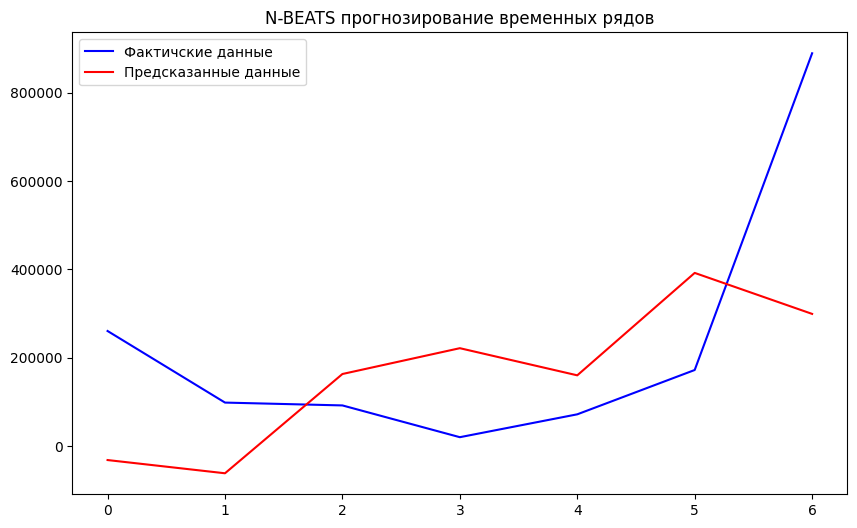

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Фактичские данные', color='blue')
plt.plot(predictions, label='Предсказанные данные', color='red')
plt.legend()
plt.title("N-BEATS прогнозирование временных рядов")
plt.show()

Сравнение предсказаний на всей тренировочной выборке

In [27]:
model.eval()
predictions_train = []
actuals_train = []
with torch.no_grad():
    for batch_X, batch_Y in train_loader:
        batch_X = batch_X.reshape(batch_X.size(0), -1)
        preds = model(batch_X).squeeze(-1)
        predictions_train.extend(preds.numpy())
        actuals_train.extend(batch_Y.numpy())

In [28]:
predictions_train = y_scaler.inverse_transform(np.array(predictions_train).reshape(-1, 1)).flatten()
actuals_train = y_scaler.inverse_transform(np.array(actuals_train).reshape(-1, 1)).flatten()

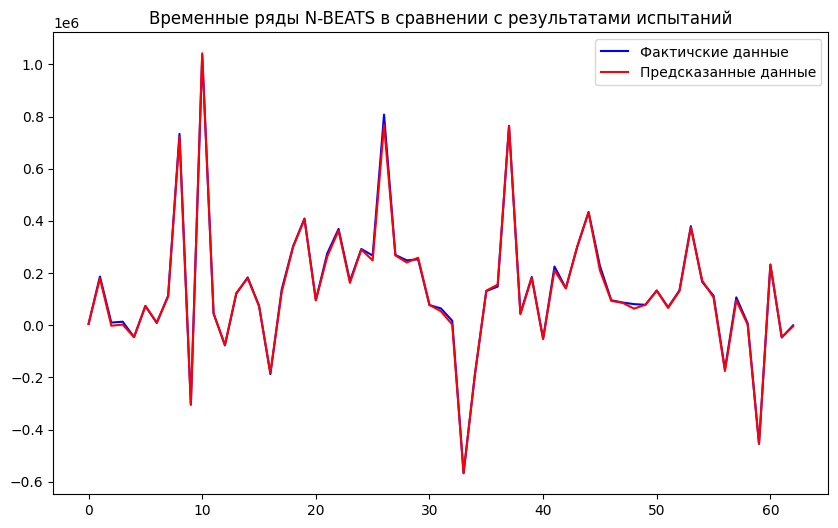

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(actuals_train, label='Фактичские данные', color='blue')
plt.plot(predictions_train, label='Предсказанные данные', color='red')
plt.legend()
plt.title("Временные ряды N-BEATS в сравнении с результатами испытаний")
plt.show()

Прогнозирование для df_forecast

In [30]:
model.eval()

NBeats(
  (blocks): ModuleList(
    (0-2): 3 x NBeatsBlock(
      (fc1): Linear(in_features=20, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=128, bias=True)
      (fc3): Linear(in_features=128, out_features=128, bias=True)
      (fc4): Linear(in_features=128, out_features=1, bias=True)
      (relu): ReLU()
    )
  )
)

In [31]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [32]:
last_known_value = df_train.drop(columns=["date", "time_idx", target_column]).iloc[-1].values
X_forecast = df_forecast.drop(columns=["date", "time_idx", target_column]).values
X_forecast = np.vstack([last_known_value, X_forecast])
scaler.fit(X_forecast)
X_forecast = scaler.fit_transform(X_forecast)

In [33]:
X_forecast[3]

array([ 1.        ,  0.77777778,  1.        ,  0.10606061, -0.43586896,
       -0.22513056, -0.30040666,  0.10246147, -0.41913043, -0.56748352])

In [34]:
forecast_sequence = []
for i in range(len(X_forecast) - sequence_length + 1):
    forecast_sequence.append(X_forecast[i:i + sequence_length])

In [35]:
forecast_sequence = torch.from_numpy(np.array(forecast_sequence)).float()
forecast_sequence = forecast_sequence.reshape(forecast_sequence.size(0), -1)

In [36]:
predictions = []
with torch.no_grad():
    for i in range(forecast_sequence.size(0)):
        input_seq = forecast_sequence[i].view(1, -1)
        pred = model(input_seq).squeeze(-1)
        predictions.append(pred.item())

In [37]:
predictions = y_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

In [38]:
len(predictions)

12

Добавление прогноза в df_forecast

In [39]:
start_idx = len(df_forecast) - len(predictions)
df_forecast.iloc[start_idx:, df_forecast.columns.get_loc(target_column)] = predictions

In [40]:
df_forecast[target_column].values

array([  467294.18350303,   693447.12280333,   427092.09465   ,
        1146755.18394613,    93836.39261505,   316993.46688336,
         855022.8107779 ,    75177.33732909, -1141799.95600581,
         -78111.97538388,  -761998.3152504 , -1299868.6496191 ])

Построение графика прогнозов

In [41]:
len(df_train_grapgh)

72

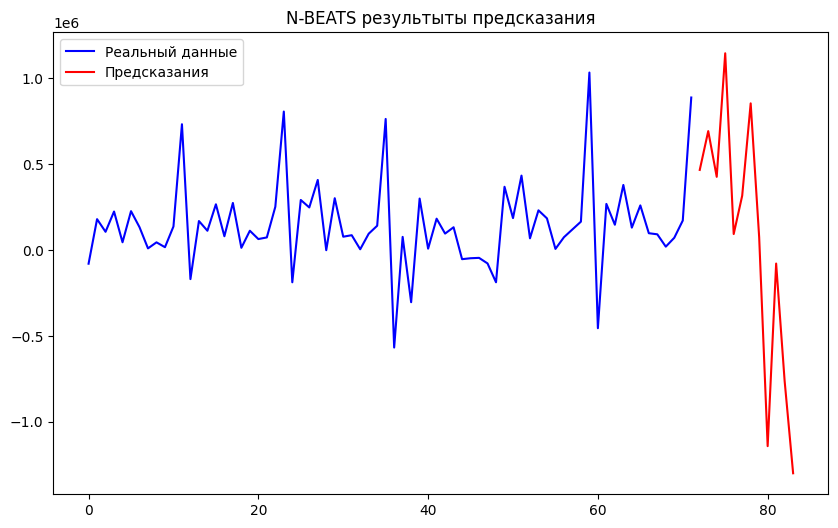

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(df_train_grapgh)), df_train_grapgh, label="Реальный данные", color="blue")
plt.plot(range(len(df_train_grapgh), len(df_train_grapgh) + len(predictions)), predictions, label="Предсказания", color="red")
plt.legend()
plt.title("N-BEATS результыты предсказания")
plt.show()

In [43]:
df_forecast.to_csv("forecast_results.csv", index=False)